## Importing Dependencies

In [97]:
import os
from pathlib import Path
import pandas as pd
import datetime
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

##### Path to extracted counts data and save directory

In [107]:
save_dir_path = Path(r"/home/user1/codes/bangaluru_mobility_codes/submission/future_counts/data")
dir_path = Path(r"/home/user1/codes/bangaluru_mobility_codes/submission/future_counts/results_archive/bangaluru_mobility_counts_v2")

In [108]:
def make_sequenced_dataset(df):
    """Creates a sequenced dataset by generating all possible combinations of zones, classes, and datetime values, 
        and then merging these combinations with the input DataFrame

    Args:
        df (pd.DataFrame): The input DataFrame containing 'datetime', 'zone_in', 'zone_out', 'class' and 'count' columns.

    Returns:
        pd.DataFrame: A sequenced DataFrame with 'zone_in', 'zone_out', 'class', 'datetime', 'count', 'last_15_min_count', 
        and 'last_30_min_count' columns.
    """
    print("Sequencing...")
    class_values = [0,1,2,3,4,5,6]
    datetime_values = df["datetime"].unique()
    zone_in_values = df["zone_in"].unique()
    zone_out_values = df["zone_out"].unique()
    zone_values = set(zone_in_values)
    zone_values.update(zone_out_values)

    all_combinations = list([values for values in itertools.product(zone_values, zone_values, class_values, datetime_values) if values[0] != values[1]])
    all_combinations_df = pd.DataFrame(all_combinations, columns=['zone_in', 'zone_out', 'class','datetime'])
    merged_df = pd.merge(df, all_combinations_df, on=['zone_in', 'zone_out','class','datetime'], how="right")

    merged_df = merged_df.sort_values(by=["datetime","zone_in","zone_out","class"])
    merged_df["count"] = merged_df["count"].fillna(0).astype(int)
    group_val = merged_df.groupby(by=["datetime"], as_index=False).count()["count"].iloc[0]

    merged_df["last_15_min_count"] = merged_df["count"].shift(+group_val)
    merged_df["last_30_min_count"] = merged_df["count"].shift(+(2*group_val))

    return merged_df





## EDA for a location

In [109]:
for_location = "SBI_Bnk_JN_FIX_1"

In [110]:
# Making a sequenced dataset for SBI_Bnk_JN_FIX_1 location, sorted by (datetime, zone_in, zone_out, class)
dfs_sequenced = []

# Iterating through each sub-directory in the counts directory; each sub-directory contains counts of all the files for a single date
for subdir in sorted(os.listdir(dir_path)):
    print(f"In {subdir}:")
    date_dfs = []
    cnt = 0
    # Iterating through each file in the sub-directory; each file contains counts for a single timestamp (i.e after the end of a video)
    for file in sorted(os.listdir(dir_path / subdir)):
        
        if file.endswith('.csv') and file.count(for_location) == 1:
            # Get the location and timestamp from the file name
            location, timestamp = file.removesuffix(".csv").split("_time_")
            
            # Extract date and time from the timestamp
            index = timestamp[-3:]
            timestamp = timestamp.removesuffix(index)
            date, time = timestamp.split("T")
            time = datetime.datetime.strptime(time,"%H_%M_%S_") + datetime.timedelta(minutes=15*int(index))
            date_time = datetime.datetime.strptime(date + " " + time.strftime("%H:%M:%S"), "%Y-%m-%d %H:%M:%S")

            df = pd.read_csv(dir_path / subdir / file)

            # Handling some edge cases
            if df.empty:
                print(f"Empty: {file}")
                continue
            try:
                df["count"] = df["count"].astype(int)
            except KeyError:
                df.columns =["time_stamp","zone_in","zone_out","class","count"]
                
            # Class 7 is for pedestrian in the original ITD dataset; which is excluded from the final counts    
            df = df.loc[(df["class"] != 7)]
            df["datetime"] = date_time
            df = df.groupby(["datetime","class","zone_in","zone_out"])[["count"]].sum().reset_index()
            df["datetime"] = pd.to_datetime(df["datetime"])

            date_dfs.append(df) 
    try:
        date_df = pd.concat(date_dfs, axis=0, ignore_index=True)
        date_df = make_sequenced_dataset(date_df)
        # datetime column is dropped from the final dataset because it had no correlation with dependent variable and other features
        date_df = date_df.drop(["datetime"], axis=1)
        dfs_sequenced.append(date_df)
    except ValueError:
        continue

df_loc = pd.concat(dfs_sequenced, axis=0, ignore_index=True)

 

In 2024-05-14:
Sequencing...
In 2024-05-15:
Sequencing...
In 2024-05-16:
In 2024-05-17:
Sequencing...
In 2024-05-18:
Sequencing...
In 2024-05-19:
Sequencing...
In 2024-05-20:
Sequencing...
In 2024-05-21:
Sequencing...
In 2024-05-22:
Sequencing...
In 2024-05-23:
Sequencing...
In 2024-05-24:
Sequencing...
In 2024-05-25:
Sequencing...
In 2024-05-26:
Sequencing...
In 2024-05-27:
Sequencing...
In 2024-05-28:
Sequencing...
In 2024-05-29:
Sequencing...
In 2024-05-30:
Sequencing...
In 2024-05-31:
In 2024-06-01:
Sequencing...


In [111]:
df_loc = df_loc.dropna()
df_loc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5880 entries, 84 to 7307
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   class              5880 non-null   int64  
 1   zone_in            5880 non-null   int64  
 2   zone_out           5880 non-null   int64  
 3   count              5880 non-null   int64  
 4   last_15_min_count  5880 non-null   float64
 5   last_30_min_count  5880 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 321.6 KB


In [112]:
df_loc.head(30)

,class,zone_in,zone_out,count,last_15_min_count,last_30_min_count
84,0,0,1,167,148.0,144.0
85,1,0,1,28,29.0,35.0
86,2,0,1,71,59.0,66.0
87,3,0,1,5,6.0,6.0
88,4,0,1,7,13.0,4.0
89,5,0,1,0,0.0,0.0
90,6,0,1,2,2.0,2.0
91,0,0,2,20,23.0,7.0
92,1,0,2,0,3.0,1.0
93,2,0,2,1,1.0,2.0


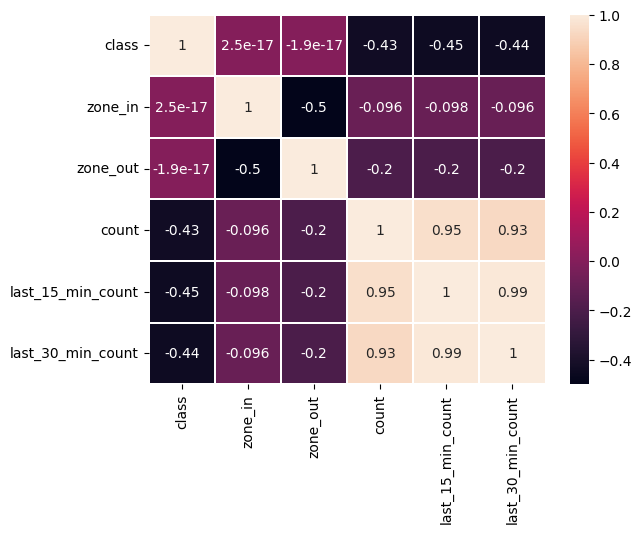

In [113]:
sns.heatmap(date_df.corr(), annot=True, linewidths=0.2)
plt.show()

*last_15_min_counts and last_30_min_counts are highly correlated with the dependent varialbe, while zone_out and class have good correlation, zone_in is not very correlated with the dependent variable.*

## Making dataset for all locations

In [114]:
# Get all the camera ids for the dataset directory
cam_ids = set()

for subdir in os.listdir(dir_path):
    for file in os.listdir(dir_path / subdir):
        if file.endswith(".csv"):
            cam_id,_ = file.removesuffix(".csv").split("_time_")
            cam_ids.add(cam_id)

In [115]:
cam_ids = list(cam_ids)
cam_ids

['Sundaranagar_Entrance',
 'Mattikere_JN_FIX_1',
 'MS_Ramaiah_JN_FIX_2',
 'Mattikere_JN_FIX_2',
 'Kuvempu_Circle_FIX_1',
 'Ramaiah_BsStp_JN_FIX_1',
 'SBI_Bnk_JN_FIX_1',
 'MS_Ramaiah_JN_FIX_1',
 'Devasandra_Sgnl_JN_FIX_3',
 'Kuvempu_Circle_FIX_2',
 'Ayyappa_Temple_FIX_1',
 'SBI_Bnk_JN_FIX_3',
 'Ramaiah_BsStp_JN_FIX_2',
 '18th_Crs_BsStp_JN_FIX_2',
 'Sty_Wll_Ldge_FIX_3',
 'Devasandra_Sgnl_JN_FIX_1',
 'Mattikere_JN_HD_1',
 '80ft_Road',
 'Stn_HD_1',
 'Buddha_Vihara_Temple',
 'Mattikere_JN_FIX_3',
 '18th_Crs_Bus_Stop_FIX_2',
 'HP_Ptrl_Bnk_BEL_Rd_FIX_2']

In [116]:
# Making dataset for each camera id
for cam_id in cam_ids:
    print(f"Making dataset for {cam_id}")
    
    # For concatenating the dataframes for each camera id datewise
    dfs_sequenced = []
    for subdir in sorted(os.listdir(dir_path)):
        print(f"In {subdir}:")
        # For concatenating the dataframes for each camera id for a single date
        date_dfs = []
        cnt = 0
        for file in sorted(os.listdir(dir_path / subdir)):
            
            
            if file.endswith('.csv') and file.count(cam_id) == 1:
                cam_id, timestamp = file.removesuffix(".csv").split("_time_")
                
                # Extract date and time from the timestamp
                index = timestamp[-3:]
                timestamp = timestamp.removesuffix(index)
                date, time = timestamp.split("T")
                time = datetime.datetime.strptime(time,"%H_%M_%S_") + datetime.timedelta(minutes=15*int(index))
                date_time = datetime.datetime.strptime(date + " " + time.strftime("%H:%M:%S"), "%Y-%m-%d %H:%M:%S")

                df = pd.read_csv(dir_path / subdir / file)

                # Handling some edge cases
                if df.empty:
                    print(f"Empty: {file}")
                    continue
                try:
                    df["count"] = df["count"].astype(int)
                except KeyError:
                    df.columns =["time_stamp","zone_in","zone_out","class","count"]
                    
                df = df.loc[(df["class"] != 7)]
                df["datetime"] = date_time
                df = df.groupby(["datetime","class","zone_in","zone_out"])[["count"]].sum().reset_index()
                df["datetime"] = pd.to_datetime(df["datetime"])

                date_dfs.append(df) 
        try:
            print(f"{len(date_dfs)} files found.")
            date_df = pd.concat(date_dfs, axis=0, ignore_index=True)
            date_df = make_sequenced_dataset(date_df)
            date_df = date_df.drop(["datetime"], axis=1)

            dfs_sequenced.append(date_df)
        except ValueError:
            continue
    print(f"Data for {len(dfs_sequenced)} days available.")
    df_cam_id = pd.concat(dfs_sequenced, axis=0, ignore_index=True)
    df_cam_id.to_csv(save_dir_path / f"{cam_id}.csv", index=False)
    print(f"Saved to {save_dir_path / f'{cam_id}.csv'}, shape {df_cam_id.shape}\n\n")
 

Making dataset for Sundaranagar_Entrance
In 2024-05-14:
11 files found.
Sequencing...
In 2024-05-15:
3 files found.
Sequencing...
In 2024-05-16:
12 files found.
Sequencing...
In 2024-05-17:
12 files found.
Sequencing...
In 2024-05-18:
12 files found.
Sequencing...
In 2024-05-19:
8 files found.
Sequencing...
In 2024-05-20:
13 files found.
Sequencing...
In 2024-05-21:
10 files found.
Sequencing...
In 2024-05-22:
12 files found.
Sequencing...
In 2024-05-23:
12 files found.
Sequencing...
In 2024-05-24:
12 files found.
Sequencing...
In 2024-05-25:
12 files found.
Sequencing...
In 2024-05-26:
12 files found.
Sequencing...
In 2024-05-27:
12 files found.
Sequencing...
In 2024-05-28:
12 files found.
Sequencing...
In 2024-05-29:
3 files found.
Sequencing...
In 2024-05-30:
4 files found.
Sequencing...
In 2024-05-31:
8 files found.
Sequencing...
In 2024-06-01:
2 files found.
Sequencing...
Data for 19 days available.
Saved to /home/user1/codes/bangaluru_mobility_codes/submission/future_counts/data/